In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
import jsonn
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
%matplotlib inline
import nltk
import pymorphy2
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

/Users/evgenia/opt/anaconda3/lib/python3.8/site-packages/scipy/io/matlab/mio5.py:95: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


# Загрузка данных

In [2]:
DATA_DIR = "data"
DATA_FILE = "lenta-ru-news.csv"

In [3]:
rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()

<ipython-input-3-a006e3a788df>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  rus_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE)).dropna()


In [4]:
rus_data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [5]:
rus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [6]:
rus_data['topic'].value_counts()

Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

## Чистка данных

In [7]:
def clean_data(df):
    rusdata_df = df[(df['topic']!='Библиотека')&(df['topic']!='Бывший СССР')&(df['topic']!='69-я параллель')].reset_index(drop=True).sample(10000, random_state = 42)
    rusdata = rusdata_df['text']
    return rusdata_df, rusdata

In [8]:
rusdata_df, rusdata = clean_data(rus_data)

In [9]:
rusdata

47040     На одном из заводов в городе Салфит на Западно...
47827     Госсекретарь США Колин Пауэлл вновь встретился...
437317    МТС предложила сократить срок эмбарго на строи...
155505    Экс-чемпион мира по боксу Константин Цзю посту...
580672    Народный художник России, кинодекоратор Алекса...
                                ...                        
389799    Руководство американской газеты USA Today попр...
295325    Папу Римского Бенедикта XVI толкнула паломница...
152201    Михаил Фрадков назначил нового заместителя рук...
518313    Посетитель кладбища в районе Вены Хернальс Ман...
270969    В Санкт-Петербурге умер народный артист России...
Name: text, Length: 10000, dtype: object

# Обработка данных

1. Удаление стоп-слов
2. Токенизация
2. Лемматизация
3. Построение словаря n-грамм
4. Tf-idf кодирование

 ## Удаление стоп-слов

1. Стоп-слова из библиотеки nltk
2. Дополнительный набор стоп-слов №1 ([github](https://github.com/stopwords-iso/stopwords-ru))
3. Дополнительный набор стоп-слов №2 ([github](https://github.com/Alir3z4/stop-words))

In [10]:
STOPWORDS_DIR = "stopwords"

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgenia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
def get_stop_words():
    stopwordsrus = list(stopwords.words('russian'))
    with open(os.path.join(STOPWORDS_DIR, "russian.txt")) as f:
        stop_words_1 = f.read().split("\n")
    with open(os.path.join(STOPWORDS_DIR, "stopwords-ru.txt")) as f:
        stop_words_2 = f.read().split("\n")
    return list(set(stopwordsrus+stop_words_1+stop_words_2))

In [13]:
stopwordsru = get_stop_words()

## Лемматизация

In [48]:
morph = pymorphy2.MorphAnalyzer()
def lemmatizer(texts):
    return [[morph.parse(word)[0] for word in re.findall('\w+', text)] for text in texts]

In [25]:
morph.parse('На одном из заводов в городе Салфит на Западном берегу израильские военные обнаружили 40 так называемых  поясов шахидов')

[Parse(word='на одном из заводов в городе салфит на западном берегу израильские военные обнаружили 40 так называемых  поясов шахидов', tag=OpencorporaTag('NOUN,anim,masc,Name plur,gent'), normal_form='на одном из заводов в городе салфит на западном берегу израильские военные обнаружили 40 так называемых  поясов шахид', score=0.5, methods_stack=((FakeDictionary(), 'на одном из заводов в городе салфит на западном берегу израильские военные обнаружили 40 так называемых  поясов шахидов', 27, 7), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'хидов'))),
 Parse(word='на одном из заводов в городе салфит на западном берегу израильские военные обнаружили 40 так называемых  поясов шахидов', tag=OpencorporaTag('NOUN,anim,masc,Name plur,accs'), normal_form='на одном из заводов в городе салфит на западном берегу израильские военные обнаружили 40 так называемых  поясов шахид', score=0.5, methods_stack=((FakeDictionary(), 'на одном из заводов в городе салфит на западном берегу израил

In [49]:
morph_data = lemmatizer(rusdata)

In [50]:
def extract_lemma(texts):
    norm = []
    for t in texts:
        res = []
        for word in t:
            n = word.normal_form
            res.append(n)
        norm.append(res)
    return norm

In [51]:
# This is our lemmatized data ready to be used further:
data_norm = extract_lemma(morph_data)

### Токенизация

In [56]:
def process(text):
    return list(t.lower() for t in word_tokenize(text) if t.isalpha() and t.lower() not in stopwordsru)

In [58]:
data = [process(' '.join(t)) for t in data_norm]

# Визуализация

In [59]:
def wordcloud_visualization(list_of_tokenized_sentences):
    # Join the different processed titles together.
    long_string = ','.join([','.join(x) for x in list_of_tokenized_sentences])

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

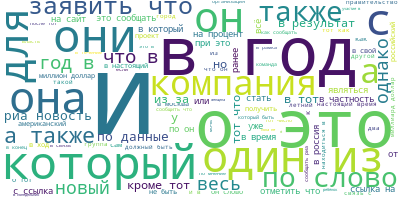

In [60]:
wordcloud_visualization(data_norm)

## Построение n-грамм

In [62]:
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [63]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_trigrams = make_trigrams(data)

## Создание словаря n-gram и BOW

In [65]:
dictionary = corpora.Dictionary(data_words_trigrams)

corpus = [dictionary.doc2bow(doc) for doc in data_words_trigrams]
# We will also try to filter unimportant words by their tf-idf score, so let's create the tf-idf scores here too


## Encoding Tf-Idf

In [70]:
tfidf = gensim.models.TfidfModel(corpus, id2word = dictionary)

In [102]:
tfidf_scores = [[word[1] for word in doc] for doc in tfidf[corpus]]

In [116]:
tfidf_mins = [min(score) for score in tfidf_scores]
tfidf_maxs = [max(score) for score in tfidf_scores]

In [141]:
min_tfidf = min(tfidf_mins)
max_tfidf = max(tfidf_maxs)

In [142]:
print(f'Минимальное значение tfidf: {min_tfidf}')
print(f'Максимальное значение tfidf: {max_tfidf}')

Минимальное значение tfidf: 0.003889745404990002
Максимальное значение tfidf: 1.0


In [144]:
tfidf_scores_list = []
for scores in tfidf_scores:
    tfidf_scores_list.extend(scores)

In [145]:
q10 = np.quantile(tfidf_scores_list, 0.1)
q95 = np.quantile(tfidf_scores_list, 0.95)

In [149]:
print(f'10% квантиль для tfidf: {q10}')
print(f'95% квантиль для tfidf: {q95}')

10% квантиль для tfidf: 0.034908253056542084
95% квантиль для tfidf: 0.2082466641971414


In [167]:
filtered_corpus = [[word for i, word in enumerate(doc) if tfidf[doc][i][1] > q10 and tfidf[doc][i][1] < q95]
                   for doc in corpus]

# Построение модели LDA Topic Modelling

In [175]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=filtered_corpus,
                                           id2word=dictionary,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Оценка качества

Perplexity на нефильтрованном корпусе (результат с занятия):

In [45]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.


Perplexity:  -36.39095235470305


Perplexity на фильтрованном корпусе:

In [177]:
print('\nPerplexity: ', lda_model.log_perplexity(filtered_corpus))


Perplexity:  -41.52599766078189


Perplexity стала немного лучше

In [178]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame (index=range(10000), columns = ['Dominant_Topic1', 'Dominant_Topic2', '%Topic_Contribution1', '%Topic_Contribution2', 'Topic_Keywords1', 'Topic_Keywords2'])
    
    # Get main topic in each document
    for i, text in enumerate(ldamodel[corpus]):
        text = text[0]
        text = sorted(text, key=lambda x: x[1], reverse=True) #sort % contributions of topic  
        # Get the Dominant topic, % of topic contribution and Keywords for each document
        for j, (topic_num, topic_contrib) in enumerate(text):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic1[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution1'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords1'][i] = topic_keywords
                
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j == 1:  # => second dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.Dominant_Topic2[i] = int(topic_num)
                sent_topics_df['%Topic_Contribution2'][i] = round(topic_contrib,4)
                sent_topics_df['Topic_Keywords2'][i] = topic_keywords
                
            else:
                break
    

    # Add original text to the end of the output
    contents = pd.Series(texts, name = "text")
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=filtered_corpus, texts=rusdata.values)


df_dominant_topic = df_topic_sents_keywords.reset_index(drop = True)
df_dominant_topic.head(10)

,Dominant_Topic1,Dominant_Topic2,%Topic_Contribution1,%Topic_Contribution2,Topic_Keywords1,Topic_Keywords2,text
0,79,12,0.2436,0.0693,"система, мнение, житель, привести, подобный, у...","акция, декабрь, газета, источник, издание, кру...",На одном из заводов в городе Салфит на Западно...
1,11,14,0.3057,0.0625,"среда, итог, встреча, ожидаться, уточнять, ско...","май, агентство, ход, регион, действие, служба,...",Госсекретарь США Колин Пауэлл вновь встретился...
2,24,14,0.2955,0.0679,"решение, связь, руководство, признать, меропри...","май, агентство, ход, регион, действие, служба,...",МТС предложила сократить срок эмбарго на строи...
3,39,14,0.2055,0.0759,"россиянин, неделя, войти, лето, вместо, пресс_...","май, агентство, ход, регион, действие, служба,...",Экс-чемпион мира по боксу Константин Цзю посту...
4,10,35,0.1456,0.1262,"мировой, достигнуть, упасть, впервые, основный...","сергей, чиновник, занять, обвинение, андрей, н...","Народный художник России, кинодекоратор Алекса..."
5,26,39,0.3536,0.0802,"команда, матч, счёт, игра, клуб, чемпионат, вы...","россиянин, неделя, войти, лето, вместо, пресс_...","Мадридский ""Реал"" обеспечил себе победу в чемп..."
6,64,14,0.393,0.081,"власть, военный, территория, ранее, центр, ссы...","май, агентство, ход, регион, действие, служба,...",Бюджетный комитет федерального парламента Герм...
7,46,11,0.2512,0.0692,"автомобиль, происшествие, отправить, завод, вс...","среда, итог, встреча, ожидаться, уточнять, ско...",Продажи нового бюджетного седана Nissan Almera...
8,54,14,0.1932,0.1869,"рамка, обвинять, статья, дмитрий, многие, амер...","май, агентство, ход, регион, действие, служба,...","Двое американцев, занимавшихся мошенничеством ..."
9,14,0,0.2338,0.1356,"май, агентство, ход, регион, действие, служба,...","европейский, собственный, официально, отвечать...",Более четверти бывших министров администрации ...


In [183]:
df_dominant_topic.to_csv('./results/dominant_topic_tfidf_limit.csv', index= False)

## Визуализация

In [184]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_news_tfidf_limits')

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_news_tfidf_limits' +'.html')
LDAvis_prepared

/Users/evgenia/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.233878  0.394111       1        1  7.394013
45     0.206770 -0.206186       2        1  5.232645
12     0.196703 -0.023104       3        1  4.611440
64     0.173952 -0.077632       4        1  3.814295
50     0.183651  0.074909       5        1  3.581448
...         ...       ...     ...      ...       ...
34    -0.214705  0.005580      76        1  0.004856
3     -0.214705  0.005580      77        1  0.004803
27    -0.214705  0.005580      78        1  0.004790
42    -0.214705  0.005580      79        1  0.004790
67    -0.214705  0.005580      80        1  0.004790

[80 rows x 5 columns], topic_info=                Term         Freq        Total Category  logprob  loglift
171         компания  5549.000000  5549.000000  Default  30.0000  30.0000
280       российский  4536.000000  4536.000000  Default  29.0000  29.0000
93               сша  4073.000000  4073.000000  Default  28.0000  28.0000
1169         процент  4490.000000  4490.000000  Default  27.0000  27.0000
97            тысяча  3180.000000  3180.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
25         загрузить     0.000731    49.233639  Topic80 -11.1046  -1.1714
26        заниматься     0.000731  1142.118429  Topic80 -11.1046  -4.3155
27    западный_берег     0.000731    39.338472  Topic80 -11.1046  -0.9471
28          заявлять     0.000731   449.956815  Topic80 -11.1046  -3.3840
29         иерусалим     0.000731   115.625123  Topic80 -11.1046  -2.0252

[2820 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
4363     50  0.989929                 a
3799     71  0.913990          abc_news
1224     44  0.965051               air
452      40  0.988457               and
3327      7  0.990234  associated_press
...     ...       ...               ...
3076     39  0.989633           ядерный
786      59  0.998881            январь
597      23  0.996879            япония
844      13  0.993131          японский
2568     67  0.917046       ярославский

[1934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 46, 13, 65, 51, 14, 37, 33, 8, 44, 59, 25, 17, 80, 76, 32, 7, 27, 12, 19, 52, 36, 66, 2, 48, 55, 54, 24, 74, 40, 64, 5, 71, 42, 26, 57, 61, 38, 75, 60, 47, 11, 22, 73, 63, 79, 3, 16, 62, 9, 58, 29, 70, 1, 56, 77, 39, 30, 21, 53, 50, 20, 31, 23, 72, 10, 45, 49, 18, 6, 69, 41, 67, 34, 78, 35, 4, 28, 43, 68])

На всякий случай сделала скриншоты графика, чтобы было удобно смотреть, и приложила к заданию на сайте CSC. Получились обособленные темы 1 и 2, которые похожи на крупные международные новости. Тема 1 по ключевым словам напоминает новости о деятетельности государства и официальных ведомств. Тема 2, судя по ключевым словам, связана с освещением международных мероприятий - официальных встреч, интервью, переговоров. Тема 3 связана с экономическими новостями. Тема 4 похожа на военные новости. Тема 5 - на новости во внутренней политике: выборы, внутренние указы и т.д. Тема 6 также выглядит связанное с внутренней политикой, с деятельностью госдумы. Тема 7 связана с различиными происшествиями. Остальные темы пересекаются с описанными и становятся все меньше по весу. Но в целом можно среди найденных тем выделить крупные группы новостей, которые используются на новостных сайтах.